In [1]:
import numpy as np
import experimental_methods as sim_r
import experimental_methods_freq as sim_f
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import rc

In [2]:
rc('text', usetex=False)
rc('font', family='sans-serif')

In [120]:
mu = 0.5; sigma = 1
R = (1, -1, 0)
c = (1, 1)

In [113]:
import warnings
warnings.filterwarnings("ignore")

# Test run

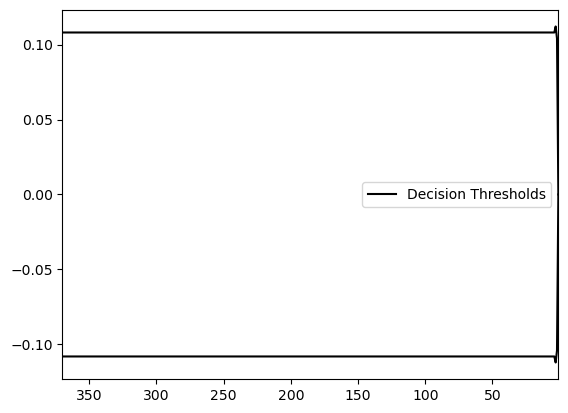

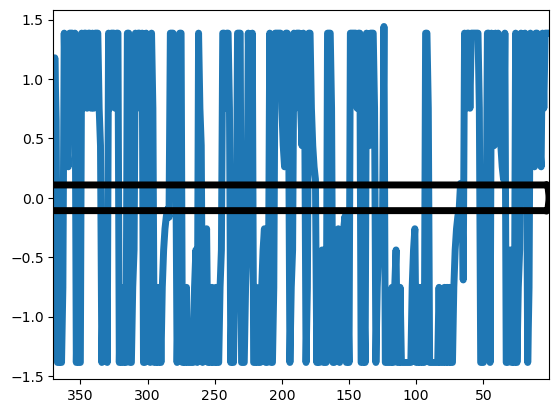

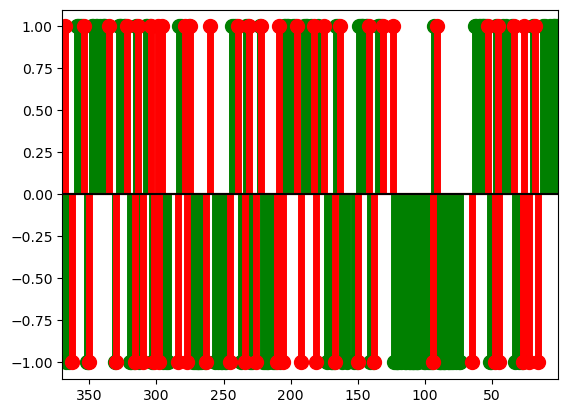

In [114]:
# Define simulation parameters:
N = 200
epsilon = 0.2; q = 0.6


# Create time step vector:
t = np.arange(N, 0, -1)

# Simulate realization of reward-maximization strategy:
block = sim_f.RewardMax(N, mu, sigma, epsilon, q, R, c)
block.experiment_sim()

# Plot reward-maximizing thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.thresh, color='black', label='Decision Thresholds')
ax.plot(t, -block.thresh, color='black')
ax.set_xlim((N, 1))
ax.legend()

# Plot belief realization over thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.belief, linewidth=5)
ax.plot(t, block.thresh, 'k', linewidth=5)
ax.plot(t, -block.thresh, 'k', linewidth=5)
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_ylim(np.max(np.abs(ax.get_ylim()))*np.array([-1, 1]))
# ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5), labels=[])
# print(ax.get_yticks())
# ax.spines[['top', 'right']].set_visible(False)

RT_rewarded = block.RT[block.reward == R[0]]
RT_punished = block.RT[block.reward == R[1]]
choice_rewarded = block.choice[block.reward == R[0]]
choice_punished = block.choice[block.reward == R[1]]

# Plot action timeseries representation:
fig, ax = plt.subplots()
if len(RT_rewarded) > 0:
    S = ax.stem(RT_rewarded, choice_rewarded, markerfmt='go', linefmt='green')
    S[0].set_markersize(10); S[1].set_linewidth(5)

if len(RT_punished) > 0:
    S = ax.stem(RT_punished, choice_punished, markerfmt='ro', linefmt='red')
    S[0].set_markersize(10); S[1].set_linewidth(5)
    
ax.plot(t, np.zeros_like(t), color='black')
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_yticks([])
# ax.spines[['top', 'right', 'left']].set_visible(False)
choicetime = block.RT
time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
dfTL = pd.DataFrame(time_lags, columns=['TL'])
dfTL['counts'] = choicetime[0:len(choicetime)-1]
lags = dfTL.groupby(dfTL['TL']).count()

# Simulating parameter space characteristics for reliability and frequency q model comparison

In [77]:
def run_sim_r(N, epsilon, q):
    block = sim_r.RewardMax(N, mu, sigma, epsilon, q, R, c)
    block.experiment_sim()
    choicetime = block.RT
    time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    mean_abs_belief = np.mean(np.abs(block.belief))
    score = block.reward_rate()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0], block.thresh[0], mean_abs_belief, score

def run_sim_f(N, epsilon, q):
    block = sim_f.RewardMax(N, mu, sigma, epsilon, q, R, c)
    block.experiment_sim()
    choicetime = block.RT
    time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    mean_abs_belief = np.mean(np.abs(block.belief))
    score = block.reward_rate()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0], block.thresh[0], mean_abs_belief, score

def compute_burstiness(lags_line):
    mean = np.mean(lags_line)
    std = np.std(lags_line)
    return (std - mean)/(std+mean)

def compute_mean(lags_line):
    return np.mean(lags_line)

def compute_std(lags_line):
    return np.std(lags_line)

def bursty_sim_f(L):
    q = []; eps = []; b_i = []; mu_i = []; std_i = []; t = []; belief = []; rewards = []; n_list = []
    for fr in np.linspace(0.01,0.99,L):
        for haz in np.linspace(0.01,0.5,L):
            print(haz,fr)
            all_lags, lags, freq, N, thresh, mab, score = run_sim_f(385, haz, fr)
            q.append(fr); eps.append(haz)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
            t.append(thresh); belief.append(mab)
            rewards.append(score); n_list.append(N)
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    t = np.array(t); t = t.reshape(-1,1)
    belief = np.array(belief); belief = belief.reshape(-1,1)
    rewards = np.array(rewards); rewards = rewards.reshape(-1,1)
    n_list = np.array(n_list); n_list = n_list.reshape(-1,1)
    return convert(q, eps, b_i, mu_i, std_i, t, belief, rewards, n_list)

def bursty_sim_r(L):
    q = []; eps = []; b_i = []; mu_i = []; std_i = []; t = []; belief = []; rewards = []; n_list = []
    for fr in np.linspace(0.5,0.99,L):
        for haz in np.linspace(0.01,0.5,L):
            print(haz,fr)
            all_lags, lags, freq, N, thresh, mab, score = run_sim_r(385, haz, fr)
            q.append(fr); eps.append(haz)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
            t.append(thresh); belief.append(mab)
            rewards.append(score); n_list.append(N)
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    t = np.array(t); t = t.reshape(-1,1)
    belief = np.array(belief); belief = belief.reshape(-1,1)
    rewards = np.array(rewards); rewards = rewards.reshape(-1,1)
    n_list = np.array(n_list); n_list = n_list.reshape(-1,1)
    return convert(q, eps, b_i, mu_i, std_i, t, belief, rewards, n_list)

def plot(q, eps, b_i):
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(121)
    plt.scatter(q,b_i)
    plt.ylim([-1, 1]); plt.xlim([0.5, 1])
    plt.xlabel('$q$'); plt.ylabel('$B$')
#     q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
#     plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,b_i)
    plt.ylim([-1, 1]); plt.xlim([0, 0.5])
    plt.xlabel('$\epsilon$'); plt.yticks([])
#     eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
#     plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
def convert(q,eps,b_i,m_i,s_i, t, mab, r, n):
    mat = np.concatenate((q,eps,b_i,m_i,s_i,t,mab, r, n), axis=1)
    return pd.DataFrame(mat, columns=['q', 'eps', 'B_i', 'mu_i', 'sig_i', 'thresh', 'mean_abs_belief', 'score', 'N_i'])

In [74]:
df_f = bursty_sim_f(10)

0.01 0.01
0.06444444444444444 0.01
0.11888888888888888 0.01
0.17333333333333334 0.01
0.22777777777777777 0.01
0.2822222222222222 0.01
0.33666666666666667 0.01
0.3911111111111111 0.01
0.44555555555555554 0.01
0.5 0.01
0.01 0.11888888888888888
0.06444444444444444 0.11888888888888888
0.11888888888888888 0.11888888888888888
0.17333333333333334 0.11888888888888888
0.22777777777777777 0.11888888888888888
0.2822222222222222 0.11888888888888888
0.33666666666666667 0.11888888888888888
0.3911111111111111 0.11888888888888888
0.44555555555555554 0.11888888888888888
0.5 0.11888888888888888
0.01 0.22777777777777777
0.06444444444444444 0.22777777777777777
0.11888888888888888 0.22777777777777777
0.17333333333333334 0.22777777777777777
0.22777777777777777 0.22777777777777777
0.2822222222222222 0.22777777777777777
0.33666666666666667 0.22777777777777777
0.3911111111111111 0.22777777777777777
0.44555555555555554 0.22777777777777777
0.5 0.22777777777777777
0.01 0.33666666666666667
0.06444444444444444 0.33

KeyboardInterrupt: 

Text(0.5, 1.0, 'Mean Absolute Belief')

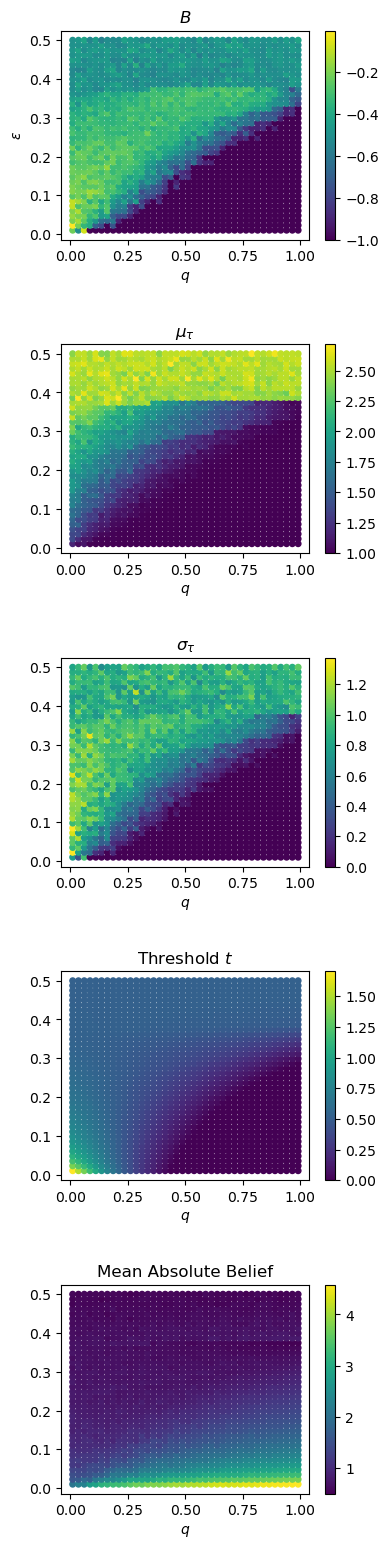

In [43]:
plt.subplots(figsize=(4,19))
plt.subplots_adjust(hspace=0.5)
plt.subplot(511)
plt.scatter(df_f['q'], df_f['eps'], c=df_f['B_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$B$')
plt.subplot(512)
plt.scatter(df_f['q'], df_f['eps'], c=df_f['mu_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\mu_\\tau$')
plt.subplot(513)
plt.scatter(df_f['q'], df_f['eps'], c=df_f['sig_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\sigma_\\tau$')
plt.subplot(514)
plt.scatter(df_f['q'], df_f['eps'], c=df_f['thresh'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('Threshold $t$')
plt.subplot(515)
plt.scatter(df_f['q'], df_f['eps'], c=df_f['mean_abs_belief'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('Mean Absolute Belief')

In [53]:
q, e, b, m, s, t, mab = bursty_sim_r(40)

0.01 0.5
0.022564102564102566 0.5
0.03512820512820513 0.5
0.047692307692307694 0.5
0.06025641025641026 0.5
0.07282051282051281 0.5
0.08538461538461538 0.5
0.09794871794871794 0.5
0.1105128205128205 0.5
0.12307692307692307 0.5
0.13564102564102565 0.5
0.1482051282051282 0.5
0.16076923076923078 0.5
0.17333333333333334 0.5
0.1858974358974359 0.5
0.19846153846153847 0.5
0.21102564102564103 0.5
0.2235897435897436 0.5
0.23615384615384616 0.5
0.24871794871794872 0.5
0.2612820512820513 0.5
0.27384615384615385 0.5
0.2864102564102564 0.5
0.298974358974359 0.5
0.31153846153846154 0.5
0.3241025641025641 0.5
0.33666666666666667 0.5
0.34923076923076923 0.5
0.3617948717948718 0.5
0.37435897435897436 0.5
0.3869230769230769 0.5
0.3994871794871795 0.5
0.41205128205128205 0.5
0.4246153846153846 0.5
0.4371794871794872 0.5
0.44974358974358974 0.5
0.4623076923076923 0.5
0.4748717948717949 0.5
0.48743589743589744 0.5
0.5 0.5
0.01 0.5125641025641026
0.022564102564102566 0.5125641025641026
0.03512820512820513 0

0.41205128205128205 0.5628205128205128
0.4246153846153846 0.5628205128205128
0.4371794871794872 0.5628205128205128
0.44974358974358974 0.5628205128205128
0.4623076923076923 0.5628205128205128
0.4748717948717949 0.5628205128205128
0.48743589743589744 0.5628205128205128
0.5 0.5628205128205128
0.01 0.5753846153846154
0.022564102564102566 0.5753846153846154
0.03512820512820513 0.5753846153846154
0.047692307692307694 0.5753846153846154
0.06025641025641026 0.5753846153846154
0.07282051282051281 0.5753846153846154
0.08538461538461538 0.5753846153846154
0.09794871794871794 0.5753846153846154
0.1105128205128205 0.5753846153846154
0.12307692307692307 0.5753846153846154
0.13564102564102565 0.5753846153846154
0.1482051282051282 0.5753846153846154
0.16076923076923078 0.5753846153846154
0.17333333333333334 0.5753846153846154
0.1858974358974359 0.5753846153846154
0.19846153846153847 0.5753846153846154
0.21102564102564103 0.5753846153846154
0.2235897435897436 0.5753846153846154
0.23615384615384616 0.5

0.13564102564102565 0.6382051282051282
0.1482051282051282 0.6382051282051282
0.16076923076923078 0.6382051282051282
0.17333333333333334 0.6382051282051282
0.1858974358974359 0.6382051282051282
0.19846153846153847 0.6382051282051282
0.21102564102564103 0.6382051282051282
0.2235897435897436 0.6382051282051282
0.23615384615384616 0.6382051282051282
0.24871794871794872 0.6382051282051282
0.2612820512820513 0.6382051282051282
0.27384615384615385 0.6382051282051282
0.2864102564102564 0.6382051282051282
0.298974358974359 0.6382051282051282
0.31153846153846154 0.6382051282051282
0.3241025641025641 0.6382051282051282
0.33666666666666667 0.6382051282051282
0.34923076923076923 0.6382051282051282
0.3617948717948718 0.6382051282051282
0.37435897435897436 0.6382051282051282
0.3869230769230769 0.6382051282051282
0.3994871794871795 0.6382051282051282
0.41205128205128205 0.6382051282051282
0.4246153846153846 0.6382051282051282
0.4371794871794872 0.6382051282051282
0.44974358974358974 0.6382051282051282

0.34923076923076923 0.701025641025641
0.3617948717948718 0.701025641025641
0.37435897435897436 0.701025641025641
0.3869230769230769 0.701025641025641
0.3994871794871795 0.701025641025641
0.41205128205128205 0.701025641025641
0.4246153846153846 0.701025641025641
0.4371794871794872 0.701025641025641
0.44974358974358974 0.701025641025641
0.4623076923076923 0.701025641025641
0.4748717948717949 0.701025641025641
0.48743589743589744 0.701025641025641
0.5 0.701025641025641
0.01 0.7135897435897436
0.022564102564102566 0.7135897435897436
0.03512820512820513 0.7135897435897436
0.047692307692307694 0.7135897435897436
0.06025641025641026 0.7135897435897436
0.07282051282051281 0.7135897435897436
0.08538461538461538 0.7135897435897436
0.09794871794871794 0.7135897435897436
0.1105128205128205 0.7135897435897436
0.12307692307692307 0.7135897435897436
0.13564102564102565 0.7135897435897436
0.1482051282051282 0.7135897435897436
0.16076923076923078 0.7135897435897436
0.17333333333333334 0.713589743589743

0.07282051282051281 0.7764102564102564
0.08538461538461538 0.7764102564102564
0.09794871794871794 0.7764102564102564
0.1105128205128205 0.7764102564102564
0.12307692307692307 0.7764102564102564
0.13564102564102565 0.7764102564102564
0.1482051282051282 0.7764102564102564
0.16076923076923078 0.7764102564102564
0.17333333333333334 0.7764102564102564
0.1858974358974359 0.7764102564102564
0.19846153846153847 0.7764102564102564
0.21102564102564103 0.7764102564102564
0.2235897435897436 0.7764102564102564
0.23615384615384616 0.7764102564102564
0.24871794871794872 0.7764102564102564
0.2612820512820513 0.7764102564102564
0.27384615384615385 0.7764102564102564
0.2864102564102564 0.7764102564102564
0.298974358974359 0.7764102564102564
0.31153846153846154 0.7764102564102564
0.3241025641025641 0.7764102564102564
0.33666666666666667 0.7764102564102564
0.34923076923076923 0.7764102564102564
0.3617948717948718 0.7764102564102564
0.37435897435897436 0.7764102564102564
0.3869230769230769 0.77641025641025

0.2864102564102564 0.8392307692307692
0.298974358974359 0.8392307692307692
0.31153846153846154 0.8392307692307692
0.3241025641025641 0.8392307692307692
0.33666666666666667 0.8392307692307692
0.34923076923076923 0.8392307692307692
0.3617948717948718 0.8392307692307692
0.37435897435897436 0.8392307692307692
0.3869230769230769 0.8392307692307692
0.3994871794871795 0.8392307692307692
0.41205128205128205 0.8392307692307692
0.4246153846153846 0.8392307692307692
0.4371794871794872 0.8392307692307692
0.44974358974358974 0.8392307692307692
0.4623076923076923 0.8392307692307692
0.4748717948717949 0.8392307692307692
0.48743589743589744 0.8392307692307692
0.5 0.8392307692307692
0.01 0.8517948717948718
0.022564102564102566 0.8517948717948718
0.03512820512820513 0.8517948717948718
0.047692307692307694 0.8517948717948718
0.06025641025641026 0.8517948717948718
0.07282051282051281 0.8517948717948718
0.08538461538461538 0.8517948717948718
0.09794871794871794 0.8517948717948718
0.1105128205128205 0.85179

0.01 0.9146153846153846
0.022564102564102566 0.9146153846153846
0.03512820512820513 0.9146153846153846
0.047692307692307694 0.9146153846153846
0.06025641025641026 0.9146153846153846
0.07282051282051281 0.9146153846153846
0.08538461538461538 0.9146153846153846
0.09794871794871794 0.9146153846153846
0.1105128205128205 0.9146153846153846
0.12307692307692307 0.9146153846153846
0.13564102564102565 0.9146153846153846
0.1482051282051282 0.9146153846153846
0.16076923076923078 0.9146153846153846
0.17333333333333334 0.9146153846153846
0.1858974358974359 0.9146153846153846
0.19846153846153847 0.9146153846153846
0.21102564102564103 0.9146153846153846
0.2235897435897436 0.9146153846153846
0.23615384615384616 0.9146153846153846
0.24871794871794872 0.9146153846153846
0.2612820512820513 0.9146153846153846
0.27384615384615385 0.9146153846153846
0.2864102564102564 0.9146153846153846
0.298974358974359 0.9146153846153846
0.31153846153846154 0.9146153846153846
0.3241025641025641 0.9146153846153846
0.336666

0.2235897435897436 0.9774358974358974
0.23615384615384616 0.9774358974358974
0.24871794871794872 0.9774358974358974
0.2612820512820513 0.9774358974358974
0.27384615384615385 0.9774358974358974
0.2864102564102564 0.9774358974358974
0.298974358974359 0.9774358974358974
0.31153846153846154 0.9774358974358974
0.3241025641025641 0.9774358974358974
0.33666666666666667 0.9774358974358974
0.34923076923076923 0.9774358974358974
0.3617948717948718 0.9774358974358974
0.37435897435897436 0.9774358974358974
0.3869230769230769 0.9774358974358974
0.3994871794871795 0.9774358974358974
0.41205128205128205 0.9774358974358974
0.4246153846153846 0.9774358974358974
0.4371794871794872 0.9774358974358974
0.44974358974358974 0.9774358974358974
0.4623076923076923 0.9774358974358974
0.4748717948717949 0.9774358974358974
0.48743589743589744 0.9774358974358974
0.5 0.9774358974358974
0.01 0.99
0.022564102564102566 0.99
0.03512820512820513 0.99
0.047692307692307694 0.99
0.06025641025641026 0.99
0.07282051282051281 

In [54]:
df_r = convert(q,e,b,m,s,t,mab)

Text(0.5, 1.0, 'Mean Absolute Belief')

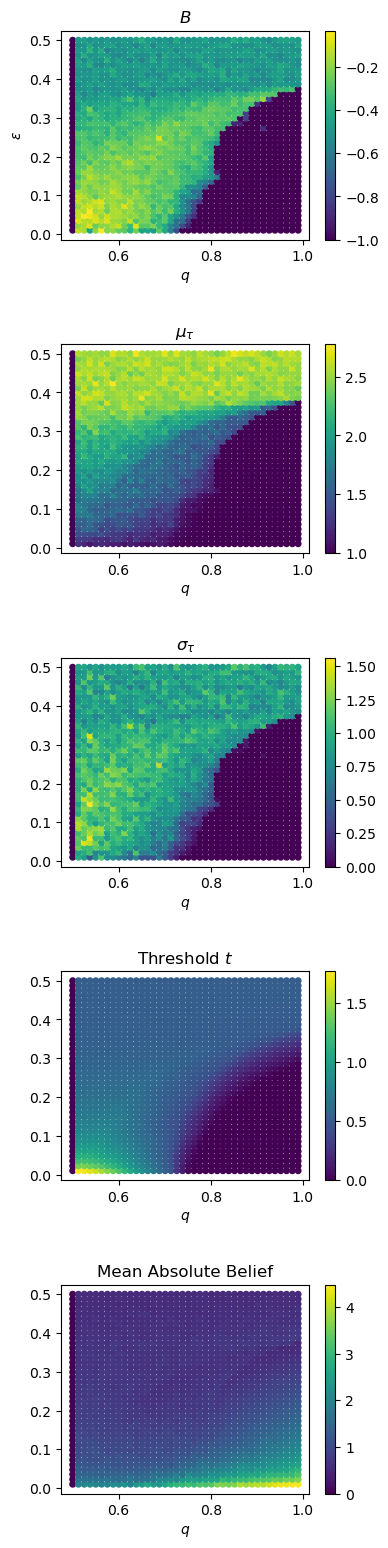

In [55]:
plt.subplots(figsize=(4,19))
plt.subplots_adjust(hspace=0.5)
plt.subplot(511)
plt.scatter(df_r['q'], df_r['eps'], c=df_r['B_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$B$')
plt.subplot(512)
plt.scatter(df_r['q'], df_r['eps'], c=df_r['mu_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\mu_\\tau$')
plt.subplot(513)
plt.scatter(df_r['q'], df_r['eps'], c=df_r['sig_i'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\sigma_\\tau$')
plt.subplot(514)
plt.scatter(df_r['q'], df_r['eps'], c=df_r['thresh'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('Threshold $t$')
plt.subplot(515)
plt.scatter(df_r['q'], df_r['eps'], c=df_r['mean_abs_belief'], s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('Mean Absolute Belief')

# Creating benchmark scores for arm3_q and arm3_eps

In [122]:
def score_sims_q(iters):
    q_params = [0.05, 0.1786, 0.3071, 0.4357, 0.5643, 0.6929, 0.8214, 0.95]; eps = 0.35
    q_set = []; eps_set = []; b_i = []; mu_i = []; std_i = []; t = []; belief = []; rewards = []; n_list = []
    for i in range(iters):
        for q in q_params:
            all_lags, lags, freq, N, thresh, mab, score = run_sim_f(370, eps, q)
            q_set.append(q); eps_set.append(eps)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
            t.append(thresh); belief.append(mab); 
            rewards.append(score*370); n_list.append(N)
        if i % 10 == 0:
            print(i)
        
    q_set = np.array(q_set); q_set = q_set.reshape(-1,1)
    eps_set = np.array(eps_set); eps_set = eps_set.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    t = np.array(t); t = t.reshape(-1,1)
    belief = np.array(belief); belief = belief.reshape(-1,1)
    rewards = np.array(rewards); rewards = rewards.reshape(-1,1)
    n_list = np.array(n_list); n_list = n_list.reshape(-1,1)
    return convert(q_set, eps_set, b_i, mu_i, std_i, t, belief, rewards, n_list)

In [145]:
df_q = score_sims_q(100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [148]:
q_params = [0.05, 0.1786, 0.3071, 0.4357, 0.5643, 0.6929, 0.8214, 0.95]
mean_score = []; stdev_score = []
for q in q_params:
    qval = df_q[df_q['q'] == q]
    score = qval['score']
    mean_score.append(np.mean(score))
    stdev_score.append(np.std(score)/np.sqrt(len(score)))
print(np.round(mean_score,0), np.sum(np.round(mean_score,0)))
print(np.round(stdev_score,2))

[  5.  15.  27.  39.  52.  67.  80. 102.] 387.0
[0.3  0.57 0.73 0.92 1.21 1.25 1.39 1.49]


In [138]:
def score_sims_eps(iters):
    length = 370
    eps_params = [0.05, 0.1143, 0.1786, 0.2429, 0.3071, 0.3714, 0.4357, 0.5]; q = 0.125
    q_set = []; eps_set = []; b_i = []; mu_i = []; std_i = []; t = []; belief = []; rewards = []; n_list = []
    for i in range(iters):
        for eps in eps_params:
            all_lags, lags, freq, N, thresh, mab, score = run_sim_f(length, eps, q)
            q_set.append(q); eps_set.append(eps)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
            t.append(thresh); belief.append(mab); 
            rewards.append(score*length); n_list.append(N)
        if i % 10 == 0:
            print(i)
        
    q_set = np.array(q_set); q_set = q_set.reshape(-1,1)
    eps_set = np.array(eps_set); eps_set = eps_set.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    t = np.array(t); t = t.reshape(-1,1)
    belief = np.array(belief); belief = belief.reshape(-1,1)
    rewards = np.array(rewards); rewards = rewards.reshape(-1,1)
    n_list = np.array(n_list); n_list = n_list.reshape(-1,1)
    return convert(q_set, eps_set, b_i, mu_i, std_i, t, belief, rewards, n_list)

In [139]:
df_eps = score_sims_eps(100)

0
10
20
30
40
50
60
70
80
90


In [150]:
eps_params = [0.05, 0.1143, 0.1786, 0.2429, 0.3071, 0.3714, 0.4357, 0.5]
mean_score = []; stdev_score = []
for eps in eps_params:
    epsval = df_eps[df_eps['eps'] == eps]
    score = epsval['score']
    mean_score.append(np.mean(score))
    stdev_score.append(np.std(score)/np.sqrt(len(score)))
print(np.round(mean_score,0), '\n', np.sum(np.round(mean_score,0)))
print(np.round(stdev_score,2))

[27. 18. 13. 11. 10. 10. 10.  9.] 
 108.0
[0.65 0.6  0.56 0.42 0.45 0.39 0.43 0.41]


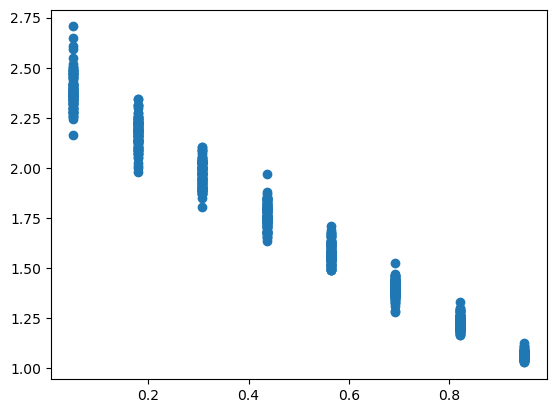

In [154]:
plt.scatter(df_q['q'], df_q['mu_i'])

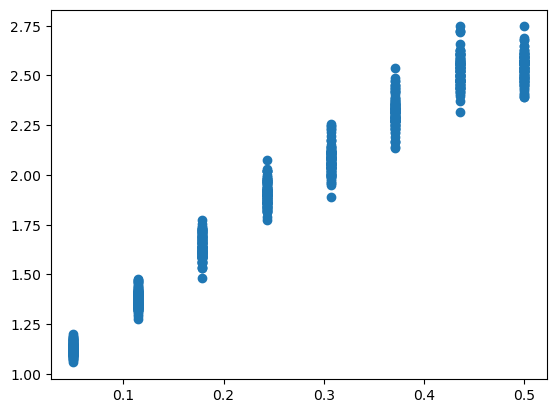

In [157]:
plt.scatter(df_eps['eps'], df_eps['mu_i'])

In [156]:
df_eps

,q,eps,B_i,mu_i,sig_i,thresh,mean_abs_belief,score,N_i
0,0.125,0.0500,-0.192762,1.173077,0.793915,0.740019,1.395240,24.0,312.0
1,0.125,0.1143,-0.263955,1.369403,0.797452,0.627842,1.039026,17.0,268.0
2,0.125,0.1786,-0.235831,1.751196,1.082842,0.575364,0.825342,12.0,209.0
3,0.125,0.2429,-0.275283,1.926702,1.094904,0.549416,0.781062,16.0,191.0
4,0.125,0.3071,-0.310234,2.114943,1.113401,0.523646,0.694811,11.0,174.0
...,...,...,...,...,...,...,...,...,...
795,0.125,0.2429,-0.332416,1.868020,0.935939,0.549416,0.762304,14.0,197.0
796,0.125,0.3071,-0.378900,2.033149,0.915795,0.523646,0.721247,1.0,181.0
797,0.125,0.3714,-0.370995,2.293750,1.052360,0.523646,0.629983,10.0,160.0
798,0.125,0.4357,-0.481869,2.469799,0.863558,0.523646,0.605462,9.0,149.0
